---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-data-analysis/resources/0dhYG) course resource._

---

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import re as re
import csv
import matplotlib.pyplot as plt
from dateutil import parser
from datetime import datetime


# Assignment 4 - Hypothesis Testing
This assignment requires more individual learning than previous assignments - you are encouraged to check out the [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/) to find functions or methods you might not have used yet, or ask questions on [Stack Overflow](http://stackoverflow.com/) and tag them as pandas and python related. And of course, the discussion forums are open for interaction with your peers and the course staff.

Definitions:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.

**Hypothesis**: University towns have their mean housing prices less effected by recessions. Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

The following data files are available for this assignment:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. For this assignment, only look at GDP data from the first quarter of 2000 onward.

Each function in this assignment below is worth 10%, with the exception of ```run_ttest()```, which is worth 50%.

In [12]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [3]:
def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. The format of the DataFrame should be:
    DataFrame( [ ["Michigan", "Ann Arbor"], ["Michigan", "Yipsilanti"] ], 
    columns=["State", "RegionName"]  )
    
    The following cleaning needs to be done:

    1. For "State", removing characters from "[" to the end.
    2. For "RegionName", when applicable, removing every character from " (" to the end.
    3. Depending on how you read the data, you may need to remove newline character '\n'. '''
    global aux
    
    uniTown = pd.read_table('university_towns.txt', names = ["RegionName", "State"])
        
    for index, row in uniTown.iterrows():

        check1 = row['RegionName'].find('(')
        check2 = row['RegionName'].find('edit')
        uniTown.loc[index, 'RegionName'] = uniTown.loc[index, 'RegionName'].strip('\n')
        uniTown.loc[index, 'RegionName'] = uniTown.loc[index, 'RegionName'].strip('\t')
        uniTown.loc[index, 'RegionName'] = uniTown.loc[index, 'RegionName'].strip()
              
        if check2 > 0:
            aux = row['RegionName'][0:(check2-1)]
            uniTown.drop(index, inplace=True)
        
        elif check1 > 0:
            uniTown.loc[index, 'RegionName'] = row['RegionName'][0:(check1-1)]
            uniTown.loc[index, 'State'] = aux
            
        else:
            uniTown.loc[index, 'State'] = aux
    
    uniTown.reset_index(inplace=True)
    uniTown = uniTown[['State', 'RegionName']]
    return uniTown

get_list_of_university_towns()

,State,RegionName
0,Alabama,Auburn
1,Alabama,Florence
2,Alabama,Jacksonville
3,Alabama,Livingston
4,Alabama,Montevallo
5,Alabama,Troy
6,Alabama,Tuscaloosa
7,Alabama,Tuskegee
8,Alaska,Fairbanks
9,Arizona,Flagstaff


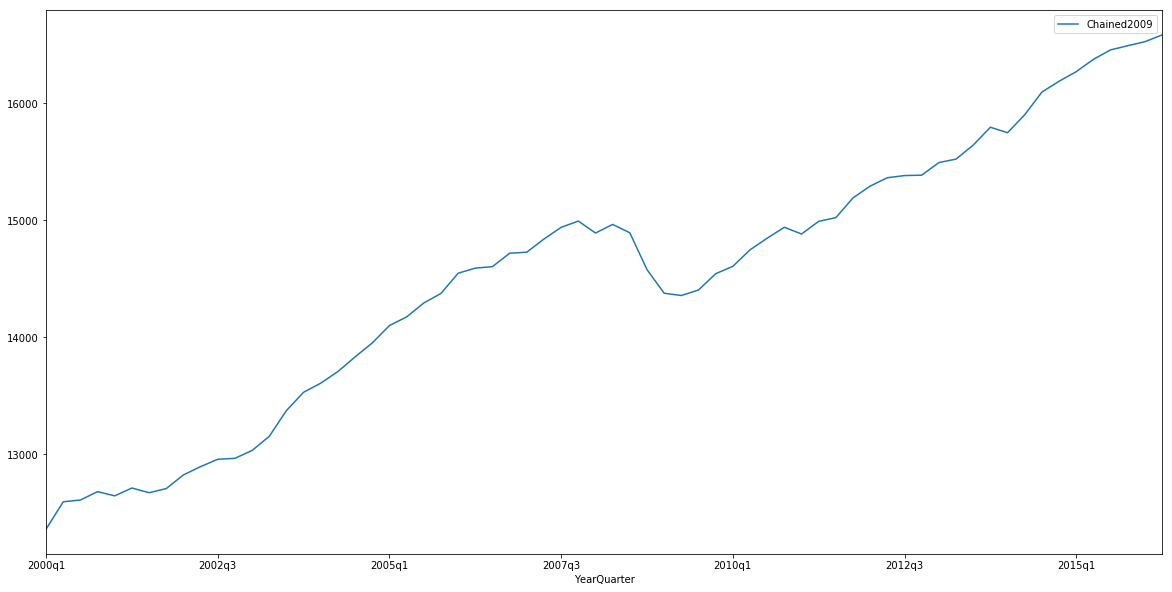

In [7]:
 '''Returns the year and quarter of the recession start time as a 
    string value in a format such as 2005q3'''
    
def get_recession_start():
    
    GDP = pd.read_excel(io='gdplev.xls', skiprows = 220, names = ['aux1','aux2','aux3','aux4','YearQuarter','aux5','Chained2009','aux6'],header = None)
    GDP = GDP[['YearQuarter','Chained2009']]
    global result
    
    for index, row in GDP.iterrows():
        if(index>0):
            if((GDP.loc[index, 'Chained2009'] < GDP.loc[index-1, 'Chained2009']) and (GDP.loc[index, 'Chained2009'] > GDP.loc[index+1, 'Chained2009']) and (GDP.loc[index-1, 'Chained2009'] > GDP.loc[index-2, 'Chained2009'])):
                result = GDP.loc[index, 'YearQuarter']
                break
    return result

get_recession_start()

'2008q3'

In [9]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time as a 
    string value in a format such as 2005q3'''
    GDP = pd.read_excel(io='gdplev.xls', skiprows = 220, names = ['aux1','aux2','aux3','aux4','YearQuarter','aux5','Chained2009','aux6'],header = None)
    GDP = GDP[['YearQuarter','Chained2009']]
    global result
    recession_start = GDP[GDP['YearQuarter'] == get_recession_start()] 
    for index, row in GDP.iterrows():
        if(index>recession_start.index):
            if((GDP.loc[index, 'Chained2009'] > GDP.loc[index-1, 'Chained2009']) and (GDP.loc[index-1, 'Chained2009'] > GDP.loc[index-2, 'Chained2009'])):
                result = GDP.loc[index, 'YearQuarter']
                break             
    return result  

get_recession_end()

'2009q4'

In [10]:
def get_recession_bottom():
    '''Returns the year and quarter of the recession bottom time as a 
    string value in a format such as 2005q3'''
    GDP = pd.read_excel(io='gdplev.xls', skiprows = 220, names = ['aux1','aux2','aux3','aux4','YearQuarter','aux5','Chained2009','aux6'],header = None)
    GDP = GDP[['YearQuarter','Chained2009']]
    global result
    recession_start = GDP[GDP['YearQuarter'] == get_recession_start()] 
    for index, row in GDP.iterrows():
        if(index>recession_start.index):
            if((GDP.loc[index, 'Chained2009'] < GDP.loc[index+1, 'Chained2009']) and(GDP.loc[index, 'Chained2009'] < GDP.loc[index-1, 'Chained2009']) and (GDP.loc[index-1, 'Chained2009'] < GDP.loc[index-2, 'Chained2009'])):
                result = GDP.loc[index, 'YearQuarter']
                break             
    return result  

get_recession_bottom()

'2009q2'

In [13]:


def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe. This dataframe should be a dataframe with
    columns for 2000q1 through 2016q3, and should have a multi-index
    in the shape of ["State","RegionName"].
    
    Note: Quarters are defined in the assignment description, they are
    not arbitrary three month periods.
    
    The resulting dataframe should have 67 columns, and 10,730 rows.
    '''
    GDP = pd.read_csv('City_Zhvi_AllHomes.csv')
    GDP1 = pd.melt(GDP, var_name = 'Date', value_name = 'Pop', id_vars=['RegionID','RegionName','State','Metro','CountyName','SizeRank'])
    GDP1['DateTime'] = GDP1['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m'))
    GDP1 = GDP1[GDP1['DateTime'] >= '2000-01-01']
    GDP1['YearQuarter'] = GDP1['Date'].apply(lambda x: str(x[0:(x.find('-'))]) + 'q' + str(int((int(x[x.find('-')+1:]) + 2)/3)))
    GDP1 = GDP1.pivot_table(values='Pop', aggfunc=np.mean, index=['SizeRank','RegionName','State'], columns='YearQuarter')
    GDP1 = GDP1.reset_index(drop=False)
    states_dic = pd.DataFrame(list(states.items()), columns=['State', 'StateName'])
    GDP2 = pd.merge(states_dic, GDP1, left_on='State', right_on = 'State', how='inner')
    GDP2 = GDP2.drop(['State','SizeRank'], axis=1)
    GDP2 = GDP2.rename(index=str, columns={"StateName": "State"})
    GDP2 = GDP2.set_index(['State','RegionName'])
    return GDP2

convert_housing_data_to_quarters()

2000q1         2000q2         2000q3  \
State    RegionName                                                       
Ohio     Columbus            94366.666667   95833.333333   97133.333333   
         Cleveland           67466.666667   67933.333333   68300.000000   
         Toledo              65100.000000   67000.000000   68533.333333   
         Akron               70100.000000   71666.666667   71866.666667   
         Dayton                       NaN            NaN            NaN   
         Canton              84533.333333   85200.000000   85733.333333   
         Hamilton           113133.333333  115166.666667  115633.333333   
         Parma              111566.666667  112300.000000  112833.333333   
         Lorain              76566.666667   78066.666667   80433.333333   
         Elyria              92666.666667   94733.333333   97600.000000   
         Medina             161400.000000  161600.000000  161866.666667   
         Lancaster           95833.333333   98833.333333  100366.666667   
         Massillon           96200.000000   97533.333333   97800.000000   
         Springfield         62466.666667   63366.666667   63866.666667   
         Loveland           170766.666667  172533.333333  174400.000000   
         Findlay            111733.333333  111400.000000  111666.666667   
         Kettering          105100.000000  107133.333333  107933.333333   
         Chillicothe         82233.333333   81166.666667   81666.666667   
         Painesville        114800.000000  116666.666667  117666.666667   
         Middletown          82700.000000   83866.666667   84366.666667   
         Mentor             143733.333333  146600.000000  147466.666667   
         Lakewood           112666.666667  113766.666667  115533.333333   
         Cleveland Heights  108533.333333  110633.333333  112800.000000   
         Cuyahoga Falls     103033.333333  105033.333333  105533.333333   
         Strongsville       173133.333333  173700.000000  174966.666667   
         Grove City         123200.000000  124700.000000  126100.000000   
         Fairfield          119400.000000  121433.333333  122666.666667   
         Brunswick          140333.333333  140833.333333  141900.000000   
         West Chester       160033.333333  162666.666667  163833.333333   
         Euclid              86900.000000   88066.666667   89533.333333   
...                                   ...            ...            ...   
Virginia Goldvein           146833.333333  152000.000000  160233.333333   
         Lyndhurst          123600.000000  123866.666667  123433.333333   
         Atkins                       NaN            NaN            NaN   
         Waterford          415733.333333  430033.333333  451500.000000   
         Bowling Green      101333.333333  102100.000000  102733.333333   
         Bremo Bluff         88233.333333   90033.333333   87700.000000   
         Henry               73400.000000   73233.333333   72933.333333   
         Sandy Hook         165733.333333  166666.666667  169266.666667   
         Monterey                     NaN            NaN            NaN   
         Mount Solon        129866.666667  126566.666667  126666.666667   
         Bent Mountain       91366.666667   93900.000000   99433.333333   
         Swoope             133133.333333  135966.666667  136800.000000   
         Goode                        NaN            NaN            NaN   
         Boston             136966.666667  137666.666667  140233.333333   
         Partlow             95866.666667  100433.333333   99733.333333   
         Bentonville        121633.333333  125300.000000  130733.333333   
         Rapidan            111100.000000  118066.666667  117500.000000   
         Laurel Fork                  NaN            NaN            NaN   
         Gladys              67033.333333   69633.333333   70033.333333   
         Doswell            125300.000000  127033.333333  126233.333333   
         North Garden       152500.000000  154533.333333  16

In [17]:
'''First creates new data showing the decline or growth of housing prices
    between the recession start and the recession bottom. Then runs a ttest
    comparing the university town values to the non-university towns values, 
    return whether the alternative hypothesis (that the two groups are the same)
    is true or not as well as the p-value of the confidence. 
    
    Return the tuple (different, p, better) where different=True if the t-test is
    True at a p<0.01 (we reject the null hypothesis), or different=False if 
    otherwise (we cannot reject the null hypothesis). The variable p should
    be equal to the exact p value returned from scipy.stats.ttest_ind(). The
    value for better should be either "university town" or "non-university town"
    depending on which has a lower mean price ratio (which is equivilent to a
    reduced market loss).'''

def run_ttest():
    recession_start = get_recession_start()
    recession_bottom = get_recession_bottom()
    university_towns = get_list_of_university_towns()
    housing1 = convert_housing_data_to_quarters()
    housing1 = housing1.reset_index(drop = False)
    housing1['VarianceRecession'] = housing1[[recession_start,recession_bottom]].apply(lambda x : x[recession_start] - x[recession_bottom], axis=1)
    merged = pd.merge(housing1, university_towns, indicator = True, left_on = ['State','RegionName'], right_on = ['State','RegionName'], how = 'left')
    merged.rename(columns={'_merge':'isUniversityTown'}, inplace=True)
    merged['isUniversityTown'] = merged['isUniversityTown'].apply(lambda x: 'Y' if x=='both' else 'N')
   
    ttest = ttest_ind(merged[merged['isUniversityTown'] == 'Y']['VarianceRecession'], merged[merged['isUniversityTown'] == 'N']['VarianceRecession'],nan_policy='omit')
    pt = merged.pivot_table(index = 'isUniversityTown', values = 'VarianceRecession', aggfunc=np.mean)
    return (ttest.pvalue<0.01, ttest.pvalue, 'university town')

run_ttest()

(True, 0.0043252148534599624, 'university town')